# Introduction to Random Forests

# Imports

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

In [282]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [104]:
from pandas.api.types import is_string_dtype, is_numeric_dtype
import os
import feather
import math
import re

In [61]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz

In [143]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Helper Functions

In [242]:
def get_samples(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

In [144]:
def parallel_trees(m, fn, n_jobs=8):
    return list(ProcessPoolExecutor(n_jobs).map(fn, m.estimators_))

In [157]:
def rf_feature_imp(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [122]:
def set_rf_samples(n):
    forest._generate_sample_indices = (lambda rs, n_samples: 
                                       forest.check_random_state(rs).randint(0, n_samples, n))
    
def reset_rf_samples():
    forest._generate_sample_indices = (lambda rs, n_samples: 
                                       forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [90]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()
            
            
def apply_cats(df, trn):
    for n, c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

In [214]:
def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1
        
        
def get_sample(df, n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()


def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n], StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_name_] = mapper.transform(df)
    return mapper


def numericalize(df, col, name, max_n_cat):
    if not is_numeric_dtype(col) and (max_n_cat is None or len(col.cat.categories) > max_n_cat):
        df[name] = col.cat.codes+1
        
        
def proc_df(df, y_fld, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if not ignore_flds: ignore_flds=[]
    if subset:
        df = get_sample(df, subset)
    else:
        df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn:
        preproc_fn(df)
    if y_fld is None:
        y = None
    else:
        if not is_numeric_dtype(df[y_fld]):
            df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)
    
    if na_dict is None:
        na_dict = {}
    else:
        na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n, c in df.items():
        na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale:
        mapper = scale_vars(df, mapper)
    for n, c in df.items():
        numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale:
        res = res + mapper
    return res

In [81]:
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [87]:
def rmse(x, y):
    return math.sqrt(((x - y)**2).mean())

def print_score(m, X_train, y_train, X_test, y_test):
    res = [rmse(m.predict(X_train), y_train),
           rmse(m.predict(X_test), y_test),
           m.score(X_train, y_train), m.score(X_test, y_test)]
    if hasattr(m, 'oob_score_'):
        res.append(m.oob_score_)
    print(res)

In [107]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {', f'Tree {{ size = {size}; ratio={ratio}', s)))

# Load the Data

In [9]:
PATH = "data/bulldozer/"

In [10]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

In [13]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000, 'display.max_columns', 1000):
        display(df)

In [19]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


In [20]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
SalesID,401125,NaN,NaN,NaN,NaN,NaN,1.91971e+06,909021,1.13925e+06,1.41837e+06,1.63942e+06,2.24271e+06,6.33334e+06
SalePrice,401125,NaN,NaN,NaN,NaN,NaN,31099.7,23036.9,4750,14500,24000,40000,142000
MachineID,401125,NaN,NaN,NaN,NaN,NaN,1.2179e+06,440992,0,1.0887e+06,1.27949e+06,1.46807e+06,2.48633e+06
ModelID,401125,NaN,NaN,NaN,NaN,NaN,6889.7,6221.78,28,3259,4604,8724,37198
datasource,401125,NaN,NaN,NaN,NaN,NaN,134.666,8.96224,121,132,132,136,172
auctioneerID,380989,NaN,NaN,NaN,NaN,NaN,6.55604,16.9768,0,1,2,4,99
YearMade,401125,NaN,NaN,NaN,NaN,NaN,1899.16,291.797,1000,1985,1995,2000,2013
MachineHoursCurrentMeter,142765,NaN,NaN,NaN,NaN,NaN,3457.96,27590.3,0,0,0,3025,2.4833e+06
UsageBand,69639,3,Medium,33985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
saledate,401125,3919,2009-02-16 00:00:00,1932,1989-01-17 00:00:00,2011-12-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### **Evaluation** - Purpose of the project
- **Root Mean Squared Log Error:**
It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [21]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

# Initial Processing

In [24]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(df_raw.drop('SalePrice', axis=1), df_raw.SalePrice)

ValueError: could not convert string to float: 'Low'

In [25]:
df_raw.saledate

0        2006-11-16
1        2004-03-26
2        2004-02-26
3        2011-05-19
4        2009-07-23
5        2008-12-18
6        2004-08-26
7        2005-11-17
8        2009-08-27
9        2007-08-09
10       2008-08-21
11       2006-08-24
12       2005-10-20
13       2006-01-26
14       2006-01-03
15       2006-11-16
16       2007-06-14
17       2010-01-28
18       2006-03-09
19       2005-11-17
20       2006-05-18
21       2006-10-19
22       2007-10-25
23       2006-10-19
24       2004-05-20
25       2006-03-09
26       2006-03-09
27       2007-02-22
28       2007-08-09
29       2006-06-01
            ...    
401095   2011-12-14
401096   2011-09-15
401097   2011-10-28
401098   2011-08-16
401099   2011-12-14
401100   2011-08-16
401101   2011-12-14
401102   2011-08-16
401103   2011-09-15
401104   2011-08-16
401105   2011-10-25
401106   2011-08-16
401107   2011-09-15
401108   2011-08-16
401109   2011-08-16
401110   2011-09-15
401111   2011-10-25
401112   2011-10-25
401113   2011-10-25


In [36]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    target_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'DayofWeek', 'DayofYear', 'Is_month_end', 'Is_month_start',
              'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[target_pre+n] = getattr(fld.dt, n.lower())
    
    df[target_pre+'Elapsed'] = fld.astype(np.int64)
    if drop: df.drop(fldname, axis=1, inplace=True)

In [39]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [40]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofWeek,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200000000000
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200000000000
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600000000000
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200000000000
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200000000000


- After running add_datepart, it added many numerical columns and removed saledate column. This is not quite enough to get passed the error we saw earlier as we still have other columns that contain string values. Pandas has a concept of a category data type, but by default it would not turn anything into a category for you. For validation and test dataset, use apply_cats instead.

In [46]:
train_cats(df_raw)

In [47]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

- The order does not matter too much, but since we are going to be creating a decision tree that split things at a single point (i.e. High vs. Low and Medium , High and Low vs. Medium ) which is a little bit weird. To order them in a sensible manner, you can do the following:

In [48]:
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

In [49]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

- Reading CSV took about 10 seconds, and processing took another 10 seconds, so if we do not want to wait again, it is a good idea to save them. Here we will save it in a feather format. What this is going to do is to save it to disk in exactly the same basic format that it is in RAM. This is by far the fastest way to save something, and also to read it back

In [52]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [57]:
# df_raw = pd.read_feather('tmp/raw')
df_raw = feather.read_dataframe('tmp/bulldozers-raw')

In [68]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [70]:
df.columns

Index(['SalesID', 'MachineID', 'ModelID', 'datasource', 'auctioneerID',
       'YearMade', 'MachineHoursCurrentMeter', 'UsageBand', 'fiModelDesc',
       'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries', 'fiModelDescriptor',
       'ProductSize', 'fiProductClassDesc', 'state', 'ProductGroup',
       'ProductGroupDesc', 'Drive_System', 'Enclosure', 'Forks', 'Pad_Type',
       'Ride_Control', 'Stick', 'Transmission', 'Turbocharged',
       'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower',
       'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control',
       'Tire_Size', 'Coupler', 'Coupler_System', 'Grouser_Tracks',
       'Hydraulics_Flow', 'Track_Type', 'Undercarriage_Pad_Width',
       'Stick_Length', 'Thumb', 'Pattern_Changer', 'Grouser_Type',
       'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofWeek', 'saleDayofYear',
       'saleI

In [69]:
df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,999089,3157,121,3.0,2004,68.0,3,950,296,...,320,False,False,False,False,False,False,1163635200000000000,False,False
1,1139248,117657,77,121,3.0,1996,4640.0,3,1725,527,...,86,False,False,False,False,False,False,1080259200000000000,False,False
2,1139249,434808,7009,121,3.0,2001,2838.0,1,331,110,...,57,False,False,False,False,False,False,1077753600000000000,False,False
3,1139251,1026470,332,121,3.0,2001,3486.0,1,3674,1375,...,139,False,False,False,False,False,False,1305763200000000000,False,False
4,1139253,1057373,17311,121,3.0,2007,722.0,2,4208,1529,...,204,False,False,False,False,False,False,1248307200000000000,False,False


In [91]:
display_all(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 66 columns):
SalesID                        401125 non-null int64
MachineID                      401125 non-null int64
ModelID                        401125 non-null int64
datasource                     401125 non-null int64
auctioneerID                   401125 non-null float64
YearMade                       401125 non-null int64
MachineHoursCurrentMeter       401125 non-null float64
UsageBand                      401125 non-null int8
fiModelDesc                    401125 non-null int16
fiBaseModel                    401125 non-null int16
fiSecondaryDesc                401125 non-null int16
fiModelSeries                  401125 non-null int8
fiModelDescriptor              401125 non-null int16
ProductSize                    401125 non-null int8
fiProductClassDesc             401125 non-null int8
state                          401125 non-null int8
ProductGroup                   401125 non-

None

In [72]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=100)
m.fit(df, y)
m.score(df,y)

0.988166252593535

In [97]:
n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [94]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 1min 21s, sys: 1.5 s, total: 1min 22s
Wall time: 19 s
[0.09061355954954195, 0.24893667768215128, 0.9828398449284822, 0.8893310594834318]


#### **Day2**

# Speeding Things Up

In [98]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [99]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
%time m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 3.18 s, sys: 40.1 ms, total: 3.22 s
Wall time: 709 ms
[0.11348213290697517, 0.3702723650457299, 0.9717717034572221, 0.7551553752233805]


# Single Tree

In [100]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.5241173757357673, 0.5814956254829238, 0.3978747950046949, 0.3961335828278988]


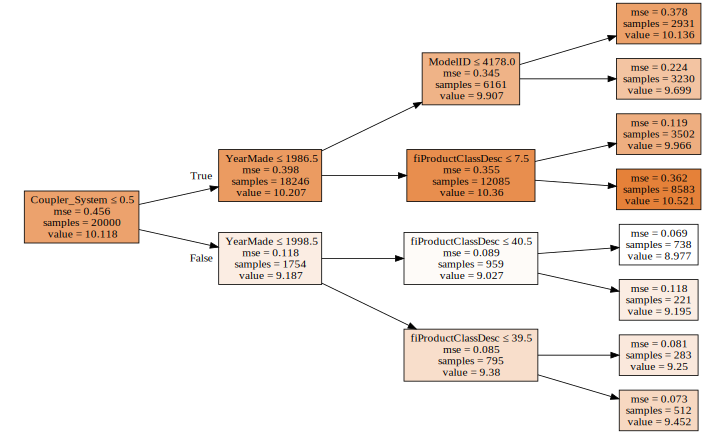

In [108]:
draw_tree(m.estimators_[0], df_trn, precision=3)

In [109]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[5.329070518200751e-17, 0.4599029172101684, 1.0, 0.6222710227887016]


- The training set result looks great! But the validation set is worse than our original model. This is why we need to use bagging of multiple trees to get more generalizable results.

# Bagging

### Intro to bagging

In [110]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.11465770450428632, 0.3769302666271339, 0.9711838353443195, 0.7462710645304149]


In [112]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:, 0], np.mean(preds[:, 0]), y_valid[0]

(array([9.39266, 8.9872 , 9.41328, 8.9359 , 8.96188, 9.23014, 9.41328, 9.15905, 8.9872 , 9.21034]),
 9.169093098982911,
 9.104979856318357)

In [113]:
preds.shape

(10, 12000)

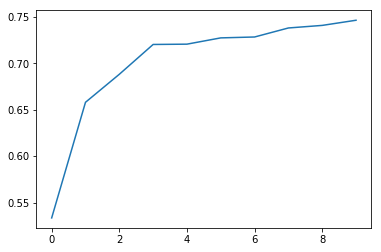

In [115]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [116]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.1035008338819158, 0.3559256654344597, 0.9765189567138296, 0.7737614621632699]


In [117]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.09771546414204646, 0.35787682022404227, 0.979070623530246, 0.7712742218148883]


In [118]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.09536182947036399, 0.3514006041016172, 0.9800667166657824, 0.7794774623162948]


#### Out-of-bag (OOB) score

In [119]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.09838575342763256, 0.3534482280792128, 0.9787825042912409, 0.7768999890764694, 0.8494234642501054]


## Reducing Overfitting

## Subsampling
- The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [121]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valif = split_vals(y_trn, n_trn)

In [123]:
set_rf_samples(20000)

In [124]:
m = RandomForestRegressor(n_estimators=10, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 9.37 s, sys: 706 ms, total: 10.1 s
Wall time: 5.24 s
[0.23990487446516304, 0.27640415118724865, 0.8797145851192265, 0.8635614496444788, 0.867088334730642]


In [125]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 36.1 s, sys: 1.84 s, total: 37.9 s
Wall time: 14.7 s
[0.22665935501040713, 0.26148163561659793, 0.8926302051603732, 0.8778958682604862, 0.8811235648996723]


In [126]:
reset_rf_samples()

In [127]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 6min 35s, sys: 6.04 s, total: 6min 41s
Wall time: 1min 11s
[0.07852638730476634, 0.23826864780414497, 0.987112577652094, 0.8986131163355662, 0.9081768937207654]


In [128]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.11494578100871228, 0.23392998459777492, 0.9723865355899936, 0.9022718318143936, 0.908655999562983]


In [129]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.1191312006126675, 0.22872434178845424, 0.9703389949102332, 0.9065729261391859, 0.9116967137330589]


# Day3

## Confidence based on tree Variance

In [135]:
PATH = "data/bulldozer/"

df_raw = feather.read_dataframe('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [136]:
n_valid = 12000
n_trn = len(df)- n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)
X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [138]:
df_raw.sample(10)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofWeek,saleDayofYear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
371577,2648458,9.680344,1906291,4641,149,1.0,1997,5155.0,Medium,410E,...,9,2,40,False,False,False,False,False,False,1297209600000000000
2235,1146707,10.668955,39785,1545,121,3.0,2001,881.0,Low,D4CIIILGP,...,20,3,141,False,False,False,False,False,False,1085011200000000000
25108,1252307,9.305651,231325,6788,132,6.0,1986,NaN,NaN,580,...,27,1,117,False,False,False,False,False,False,925171200000000000
307298,2259085,10.985293,1227220,3362,136,1.0,1986,0.0,NaN,140G,...,23,2,114,False,False,False,False,False,False,1208908800000000000
215513,1680076,9.581904,1256997,15148,132,1.0,1000,NaN,NaN,EX60-3,...,18,0,169,False,False,False,False,False,False,992822400000000000
297913,2234686,10.085809,1338958,7070,136,17.0,1996,0.0,NaN,320,...,27,1,300,False,False,False,False,False,False,1256601600000000000
270658,1809194,8.699515,1473599,9518,132,1.0,2002,NaN,NaN,463,...,13,1,256,False,False,False,False,False,False,1126569600000000000
109751,1442130,10.691945,65548,1133,132,7.0,1995,NaN,NaN,315L,...,6,3,65,False,False,False,False,False,False,1046908800000000000
182398,1616080,9.546813,1251408,8227,132,18.0,1984,NaN,NaN,610,...,13,3,347,False,False,False,False,False,False,661046400000000000
336271,2349644,9.903488,1688843,4605,136,1.0,2003,0.0,NaN,310G,...,25,2,56,False,False,False,False,False,False,1235520000000000000


In [139]:
set_rf_samples(50000)

In [140]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.20576216059495123, 0.24870861525461563, 0.9115157754527842, 0.8895337444871637, 0.8945132539135013]


In [141]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.92 s, sys: 24.5 ms, total: 1.94 s
Wall time: 1.96 s


(9.249034783372446, 0.26028217171184)

In [145]:
def get_preds(t):
    return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:, 0]), np.std(preds[:, 0])

CPU times: user 96 ms, sys: 132 ms, total: 228 ms
Wall time: 1.01 s


(9.249034783372446, 0.26028217171184)

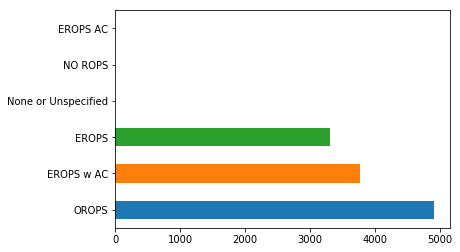

In [147]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh()

In [148]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.842863,0.273501
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.573168,0.266160
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.687637,0.224351


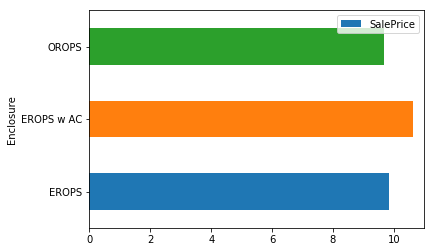

In [149]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11))

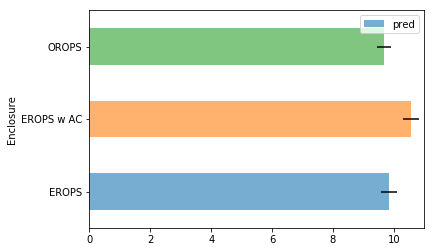

In [151]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11))

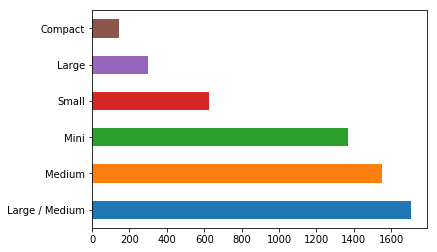

In [152]:
raw_valid.ProductSize.value_counts().plot.barh()

In [153]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.865777,0.359926
Large,10.470589,10.375945,0.360800
Large / Medium,10.691871,10.652384,0.296131
Medium,10.681511,10.620614,0.287121
Mini,9.535147,9.561372,0.248360
Small,10.324448,10.312151,0.315635


In [154]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.036482
Large             0.034773
Small             0.030608
Large / Medium    0.027799
Medium            0.027034
Mini              0.025975
dtype: float64

In [165]:
plt.subplots_adjust(bottom=.25, left=.25)

<Figure size 432x288 with 0 Axes>

In [172]:
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Feature Importance

In [158]:
fi = rf_feature_imp(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.169920
37,Coupler_System,0.120527
13,ProductSize,0.087892
14,fiProductClassDesc,0.082533
2,ModelID,0.058213
38,Grouser_Tracks,0.056181
63,saleElapsed,0.051645
10,fiSecondaryDesc,0.045545
8,fiModelDesc,0.031698
19,Enclosure,0.029488


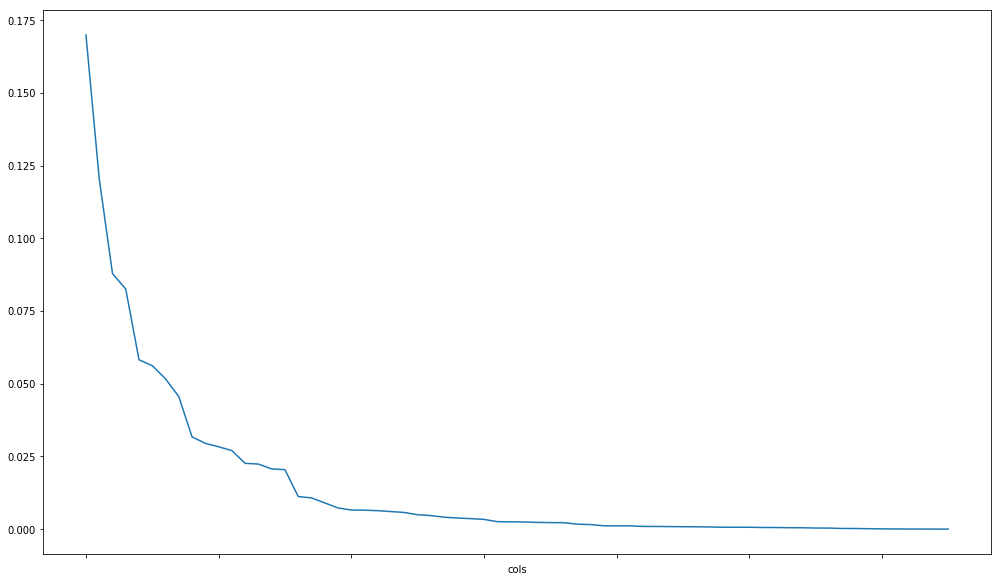

In [175]:
fi.plot('cols', 'imp', figsize=(17, 10), legend=False);

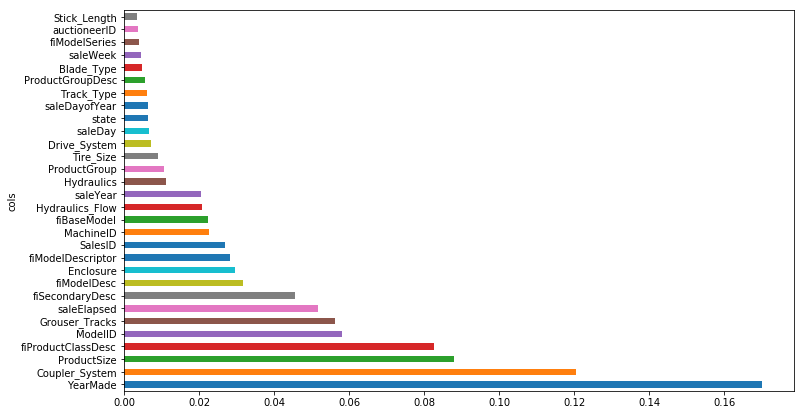

In [176]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

plot_fi(fi[:30])

In [177]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

25

In [178]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.2073249559859862, 0.24664593110311012, 0.910166568414149, 0.891358467120754, 0.8937900695576421]


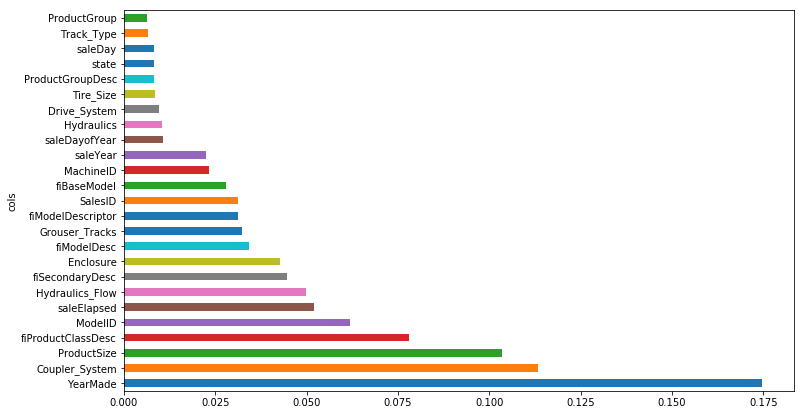

In [179]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi)

In [186]:
df_shuffle = df_keep.copy()
df_shuffle.YearMade = sklearn.utils.shuffle(df_shuffle.YearMade).values

In [189]:
df_shuffle.YearMade[10], df_keep.YearMade[10]

(1974, 2004)

In [190]:
X_train, X_valid = split_vals(df_shuffle, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.22913007292876372, 0.2877282904474791, 0.8902766616129363, 0.8521527997984175, 0.8701094558380753]


In [191]:
df_shuffle = df_keep.copy()
df_shuffle.Enclosure = sklearn.utils.shuffle(df_shuffle.Enclosure).values
df_shuffle.Enclosure[10], df_keep.Enclosure[10]

(3, 6)

In [192]:
X_train, X_valid = split_vals(df_shuffle, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.20814989934857137, 0.246819381394288, 0.9094502539776347, 0.8912056121250627, 0.8928973719362965]


In [207]:
def shuffle_test(df, flds=None):
    if flds is None:
        flds = df.columns.values
    for fld in flds:
        df_shuffle = df.copy()
        df_shuffle[fld] = sklearn.utils.shuffle(df_shuffle[fld]).values
        X_train, X_valid = split_vals(df_shuffle, n_trn)
        m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
        m.fit(X_train, y_train)
        print(fld, end='=> ')
        print_score(m, X_train, y_train, X_valid, y_valid)

In [204]:
shuffle_test(df_keep, ['YearMade', 'Coupler_System'])

YearMade=> [0.22826415001860884, 0.2877790685617961, 0.8911044221755092, 0.8521006112251459, 0.8711025817891052]
Coupler_System=> [0.20789133591325865, 0.24761847431288989, 0.9096750757216665, 0.8905000147274852, 0.8931862719700119]


In [205]:
shuffle_test(df_keep, ['ProductSize', 'saleElapsed', 'Enclosure'])

ProductSize=> [0.21355723785943892, 0.2662162996418423, 0.9046845250572545, 0.8734339404915619, 0.887058075661026]
saleElapsed=> [0.2119712190094348, 0.24919488501758566, 0.9060950207985115, 0.8891013596869248, 0.8887445842016729]
Enclosure=> [0.20770127726838414, 0.24514859215368004, 0.9098401541305345, 0.8926735459422792, 0.8933524724383535]


# One-hot Encoding

In [215]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.20749122450769483, 0.25343320989343954, 0.9100224230930567, 0.8852969351202351, 0.8922450763109423]


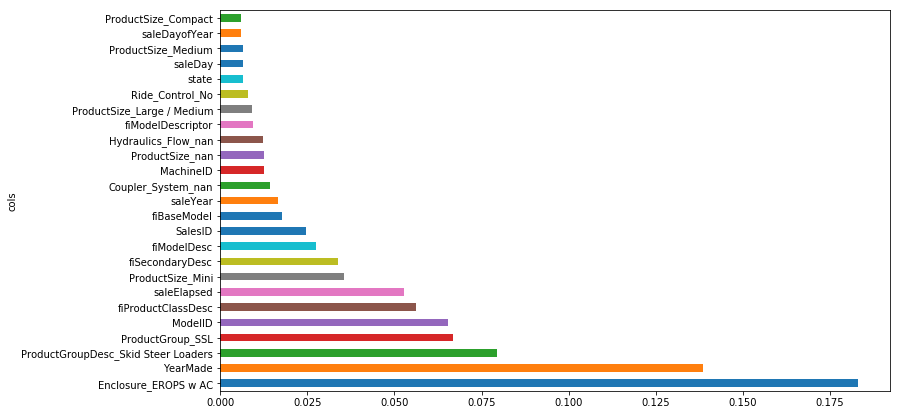

In [216]:
fi = rf_feature_imp(m, df_trn2)
plot_fi(fi[:25])

- If you have actually made an effort to turn your ordinal variables into proper ordinals, using proc_df can destroy that. The simple way to avoid that is if we know that we always want to use the codes for usage band, you could just go ahead and replace it:

- df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)
- - df_raw.UsageBand = df_raw.UsageBand.cat.codes

## Remove Redundant Features

In [217]:
from scipy.cluster import hierarchy as hc

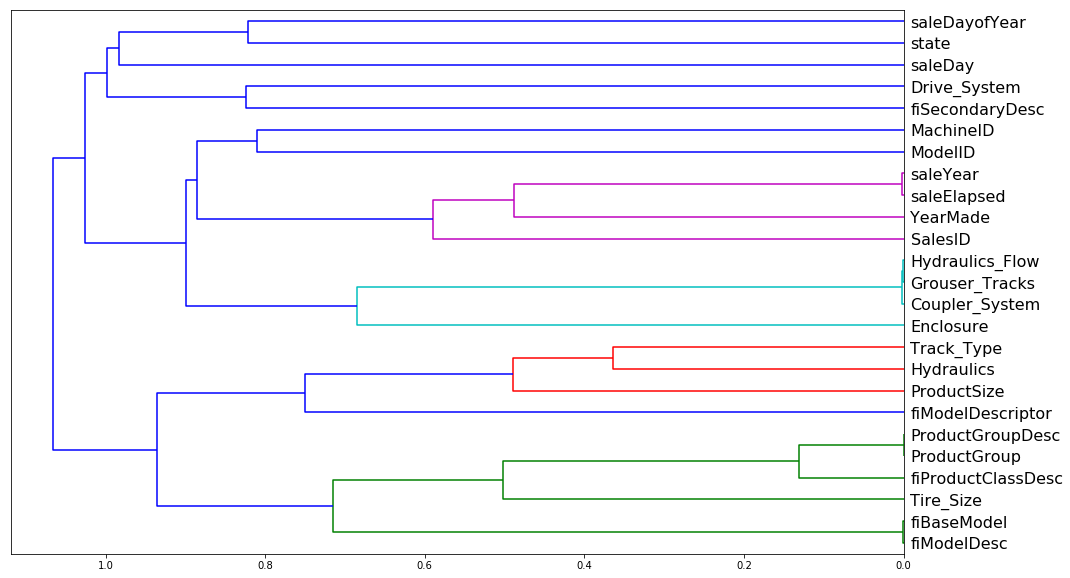

In [219]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16, 10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)


- Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [221]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [222]:
get_oob(df_keep)

0.8904346396220582

In [223]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8898712989855371
saleElapsed 0.8875411943370679
fiModelDesc 0.8886146832421786
fiBaseModel 0.8898060018073398
Grouser_Tracks 0.8903019850267466
Coupler_System 0.8900212273312522


- It looks like we can try one from each group for removal. Let's see what that does.

In [225]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8888397441170861

In [228]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [229]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [230]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [231]:
reset_rf_samples()

In [233]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.12503827384973723, 0.2273138689003236, 0.9673246110909515, 0.9077216455232504, 0.9086278419682698]


# Partial Dependence

In [234]:
from pdpbox import pdp
from plotnine import *

In [235]:
set_rf_samples(50000)

In [237]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.2077566322461424, 0.25409780101450125, 0.9097920902824626, 0.8846945626821571]


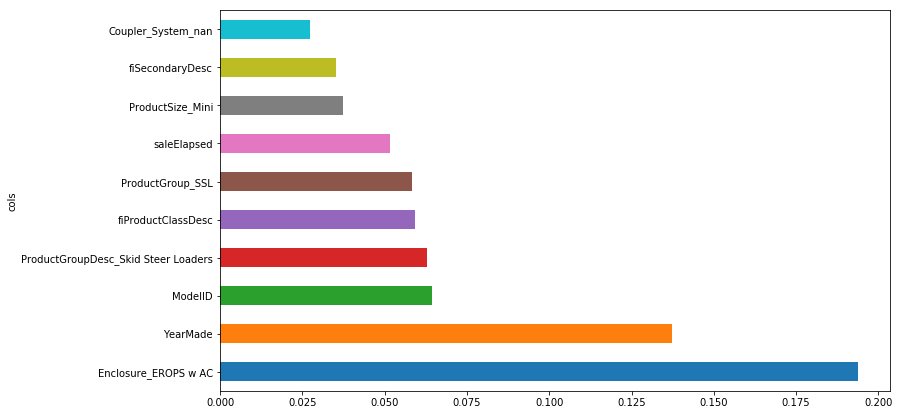

In [239]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

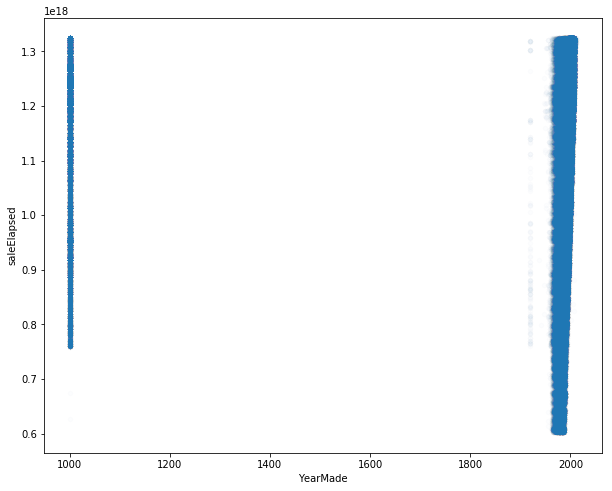

In [241]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10, 8));

In [246]:
x_all = get_sample(df_raw[df_raw.YearMade > 1930], 500)

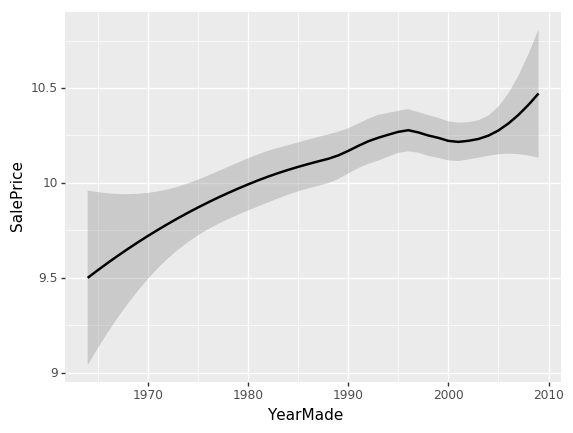

<ggplot: (7635067698)>

In [247]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [248]:
x = get_sample(X_train[X_train.YearMade > 1930], 500)

In [249]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, x.columns, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, cluster=clusters is not None, n_cluster_centers=clusters)

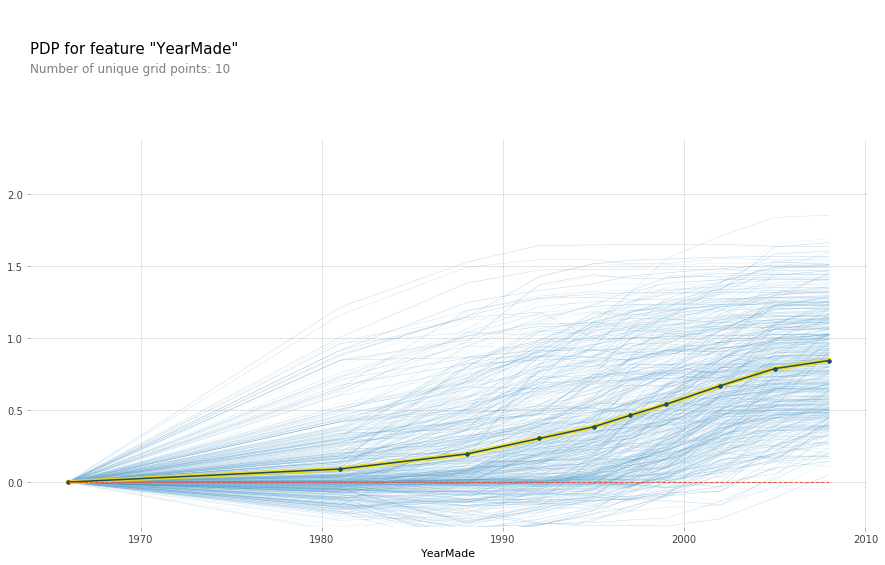

In [251]:
plot_pdp('YearMade');

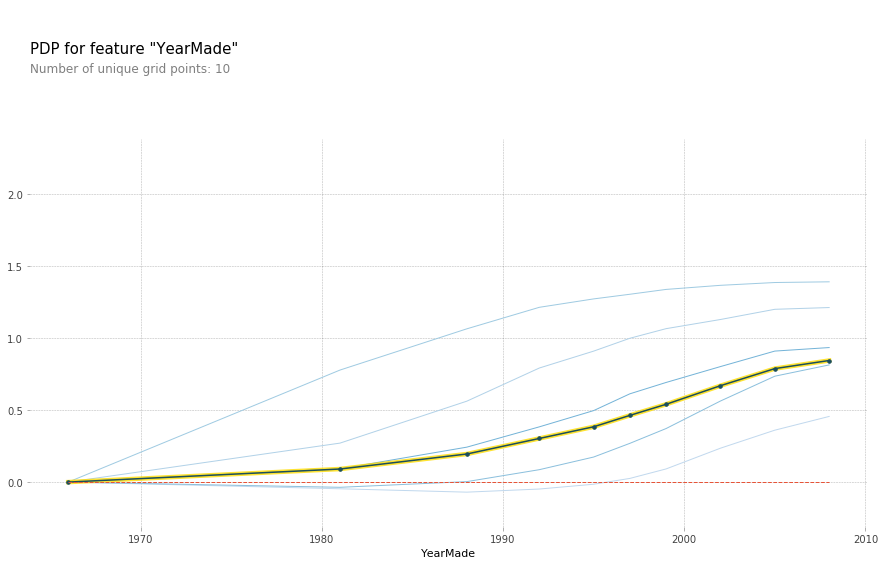

In [257]:
plot_pdp('YearMade', clusters=5);

In [ ]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, x.columns, feats)
pdp.pdp_interact_plot(p, feats)

- So if you have one-hot-encoded variables, you can pass an array of them to plot_pdp and it will treat them as a category.

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c25652438>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1c25676f28>})

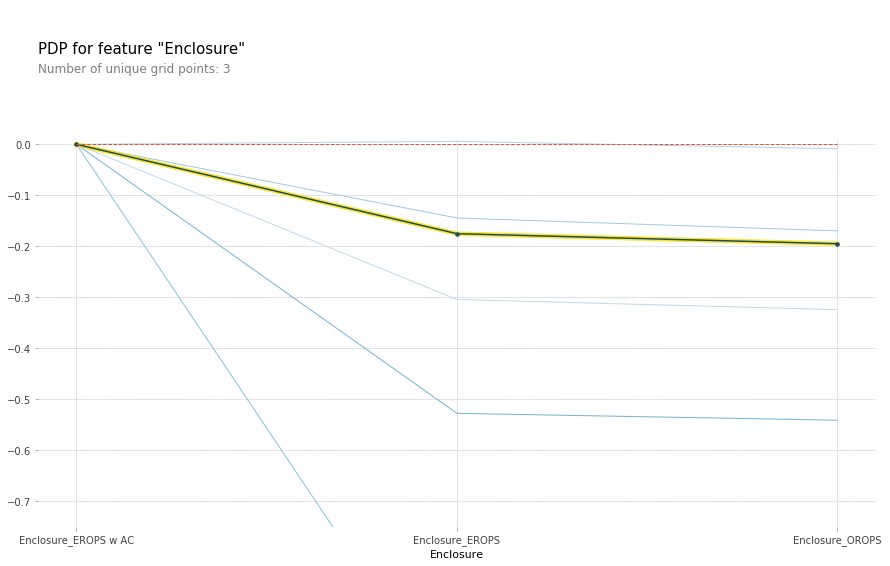

In [263]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [264]:
df_raw.YearMade[df_raw.YearMade < 1950] = 1950
df_keep['age'] = df_raw['age'] = df_raw.saleYear - df_raw.YearMade

In [265]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
       max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.2074274171501212, 0.24860611563084561, 0.910077754094837, 0.8896247780559874]


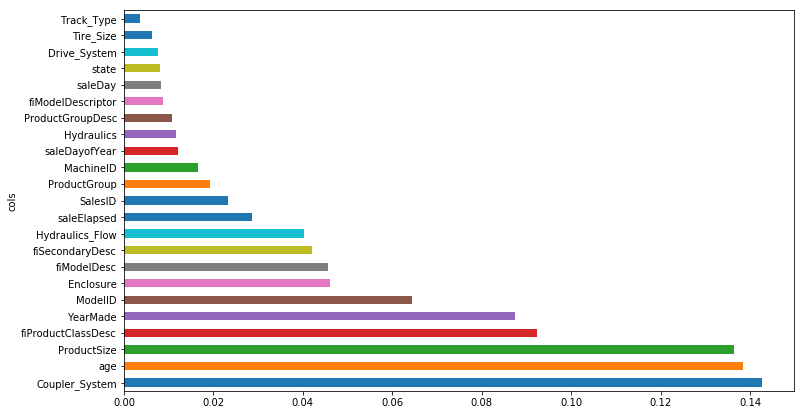

In [266]:
plot_fi(rf_feature_imp(m, df_keep))

# Tree Interpreter

In [267]:
from treeinterpreter import treeinterpreter as ti

In [268]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [269]:
row = X_valid.values[None, 0]; row

array([[               1999,                   0,                   5,                  17,
                        665, 1284595200000000000,                   0,                3232,
                          1,                   0,             4364751,             2300944,
                          0,                  12,                   4,                   0,
                          0,                  16,                  35,                 259,
                          2,                   4,                  11]])

In [270]:
prediction, bias, contributions = ti.predict(m, row)

In [273]:
prediction[0], bias[0]

(9.246063378205255, 10.106201065539775)

In [275]:
idxs = np.argsort(contributions[0])

In [277]:
[o for o in zip(df_keep.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -0.6271220541932788),
 ('age', 11, -0.12056397156990206),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -0.1141773317815424),
 ('fiModelDesc', 'KX1212', -0.055571129786186634),
 ('Enclosure', 'EROPS', -0.045469315020196535),
 ('fiSecondaryDesc', nan, -0.02998264805116113),
 ('saleElapsed', 1284595200000000000, -0.02294240762903619),
 ('MachineID', 2300944, -0.021787318436036474),
 ('saleDayofYear', 259, -0.012693683445861659),
 ('Tire_Size', nan, -0.009689320319897821),
 ('state', 'Ohio', -0.008738862867616205),
 ('fiModelDescriptor', nan, -0.0036999160597012805),
 ('SalesID', 4364751, -0.0034561331723158783),
 ('saleDay', 16, -0.002618516699329598),
 ('Drive_System', nan, 0.002154619611590869),
 ('ProductGroupDesc', 'Track Excavators', 0.0052274652752485554),
 ('Track_Type', 'Steel', 0.00681323031592389),
 ('Hydraulics', 'Standard', 0.007754605950964955),
 ('ProductGroup', 'TEX', 0.008182442146202718),
 ('Hydraulics_Flow', 

In [278]:
contributions[0].sum()

-0.8601376873345193

- build 5 models, so there might be 1. just predict the average, 2. do some kind of simple group mean of the whole data set, 3. do some group mean over the last month of the data, 4. build a random forests of the whole thing, 5, build random forest from the last three weeks. On each of those, I calculate the validation score. Then I retrain the model on the whole training set and calculate the same thing on the test set. So each of these points now tells me how well did it go on the validation set and how well did it go in the test set

- **Cross validation** says let’s not just pull out one validation set, but let’s pull out five, for example. So let’s assume that we’re going to randomly shuffle the data first of all. This is critical.

Randomly shuffle the data.
Split it into five groups
: 1\. For model №1, we will call the first one the validation set, and the bottom four the training set.
We will train and we will check against the validation and we get some RMSE, R², etc.
We will repeat that five times, and we will take the average of RMSE, R², etc, and that is a cross-validation average accuracy.

# Extrapolation

In [280]:
df_ext = df_keep.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

In [283]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9999925210345902

In [284]:
fi = rf_feature_imp(m, x); fi[:10]

,cols,imp
10,SalesID,0.813172
5,saleElapsed,0.130865
11,MachineID,0.043946
19,saleDayofYear,0.005698
4,ModelID,0.001826
0,YearMade,0.001337
8,Enclosure,0.001027
7,fiModelDesc,0.001019
1,Coupler_System,0.000262
12,Hydraulics_Flow,0.000171


In [285]:
feats=['SalesID', 'saleElapsed', 'MachineID']
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,3.891250e+05,389125.000000
mean,1800.452485,1.084797e+15,1206.796148
std,595.627288,1.803913e+14,430.850552
min,1139.246000,6.009984e+14,0.000000
25%,1413.348000,9.666432e+14,1087.016000
50%,1632.093000,1.134605e+15,1273.859000
75%,2210.453000,1.234138e+15,1458.661000
max,4364.741000,1.325117e+15,2313.821000


In [286]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,1.200000e+04,12000.000000
mean,5786.967651,1.306609e+15,1578.049709
std,836.899608,2.497808e+13,589.497173
min,4364.751000,1.174522e+15,0.830000
25%,4408.580750,1.309219e+15,1271.225250
50%,6272.538500,1.316045e+15,1825.317000
75%,6291.792250,1.321402e+15,1907.858000
max,6333.342000,1.325203e+15,2486.330000


In [287]:
x.drop(feats, axis=1, inplace=True)
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9788569647865378

In [288]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
19,age,0.241644
0,YearMade,0.192256
16,saleDayofYear,0.149585
4,ModelID,0.072317
6,fiModelDesc,0.062790
14,saleDay,0.056916
15,state,0.054376
3,fiProductClassDesc,0.033054
5,fiSecondaryDesc,0.024086
7,Enclosure,0.020622


- SalesID, saleElapsed, MachineID from the first one, age, YearMade, and saleDayofyear from the second one. They are all time dependent features. I still want them in my random forest if they are important. But if they are not important, then taking them out if there are some other none-time dependent variables that work just as well 

In [289]:
set_rf_samples(50000)

In [297]:
feats=['SalesID', 'saleElapsed', 'MachineID', 'age', 'YearMade', 'saleDayofYear']
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
                        max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.20795968137689266, 0.24837744525041838, 0.9096156762901895, 0.8898277331292022, 0.8931724735706071]


In [298]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, 
            max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m, X_train, y_train, X_valid, y_valid)

SalesID
[0.2091748237140575, 0.24469223006211718, 0.9085563296476322, 0.8930727661454051, 0.8922849327361358]
saleElapsed
[0.21379498178634032, 0.2550433546932424, 0.9044721858351923, 0.8838348123215565, 0.8873151552497892]
MachineID
[0.20663167370684574, 0.24542467960912248, 0.9107663591698647, 0.8924316667383253, 0.8950464161360643]
age
[0.20942398530629047, 0.24778579135099962, 0.908338351021015, 0.8903519853599084, 0.8916018317219851]
YearMade
[0.20877424987771406, 0.24995370514502174, 0.9089062270938811, 0.8884249393371524, 0.8922795692708365]
saleDayofYear
[0.20892026733599225, 0.24480384569253907, 0.9087787599117513, 0.8929751948198803, 0.8926479422328281]


In [299]:
reset_rf_samples()

In [300]:
df_subs = df_keep.drop(['SalesID', 'MachineID', 'saleDayofYear'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

[0.13746799931360285, 0.21754518390454253, 0.9605053699396309, 0.9154824458922367, 0.9093457333083996]


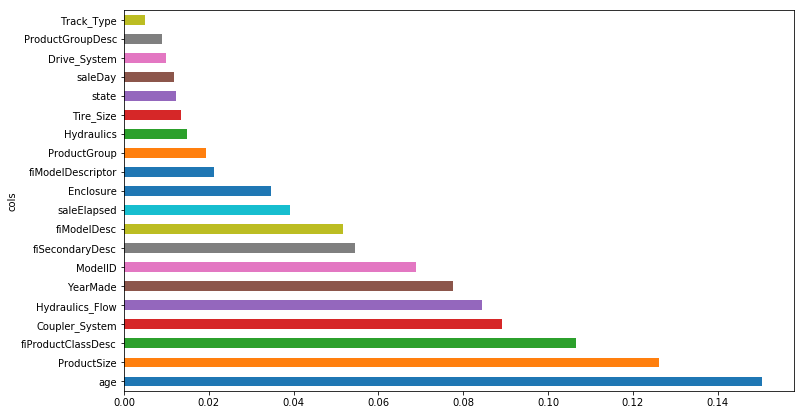

In [301]:
plot_fi(rf_feature_imp(m, X_train));

In [302]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

In [304]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m, X_train, y_train, X_valid, y_valid)

CPU times: user 5min 35s, sys: 14.1 s, total: 5min 49s
Wall time: 1min 10s
[0.08011095655993758, 0.21122144418248148, 0.9865872243323086, 0.9203246482672518, 0.9146726466863878]
